## Init

In [ ]:
!pip install pytorch-lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pytorch_lightning
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pytorch_lightning.loggers import CSVLogger,TensorBoardLogger


DATA_PATH = '/content/drive/MyDrive/deep_learning/weather_forecasting/cleaned_weather.csv'
SEED = 42
seed_everything(seed=SEED) # Seed for reproducibility

## Feature selection

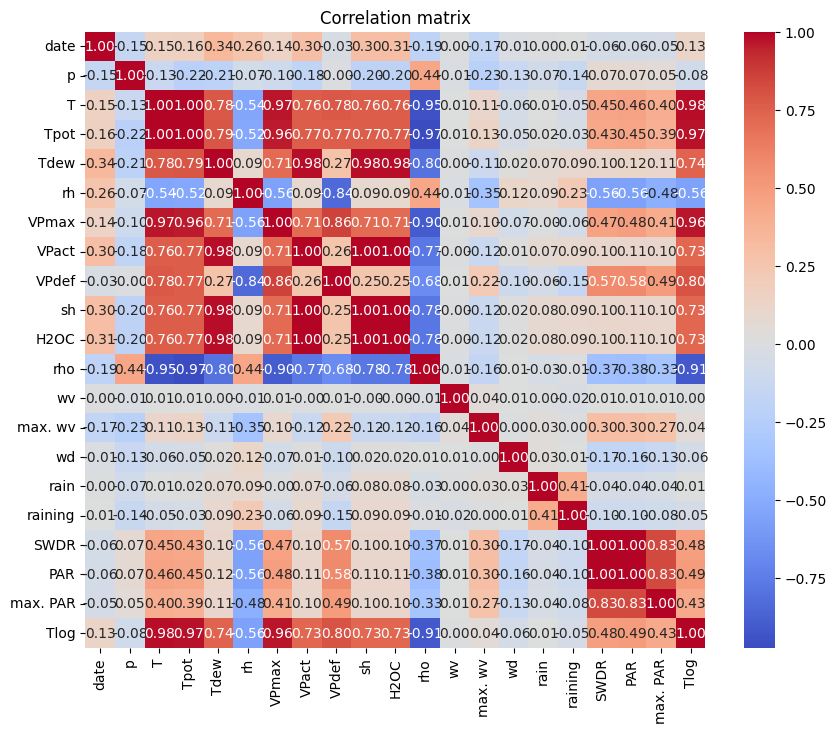

In [ ]:
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
feature_columns = [col for col in df.columns if col not in ['T', 'date']]
features = df[feature_columns]
target = df['T']

# Correlation Matrix
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [ ]:
# Remove collinearity
high_correlation_pairs = [
    (col1, col2)
    for col1 in corr.columns
    for col2 in corr.columns
    if col1 != col2 and abs(corr.loc[col1, col2]) > 0.85
]

cols_to_drop = set()
for col1, col2 in high_correlation_pairs:
    if col1 not in cols_to_drop and col2 not in cols_to_drop:
        cols_to_drop.add(col2)  # Drop one of the highly correlated columns

reduced_features = [col for col in feature_columns if col not in cols_to_drop]

print("Reduced features after removing collinearity:", reduced_features)
print("Removed features:", cols_to_drop)

# Update df with selected features
features = df[reduced_features]

In [ ]:
# Feature importance using Random Forest
model = RandomForestRegressor(random_state=SEED)
model.fit(features, target)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': reduced_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature importances:\n", feature_importance_df)

Feature importances:
      Feature    Importance
1       Tdew  6.100806e-01
3      VPdef  3.892637e-01
4         wv  1.747292e-04
0          p  1.617715e-04
5    max. wv  1.523480e-04
2         rh  1.184799e-04
6         wd  1.959009e-05
10  max. PAR  1.457454e-05
9       SWDR  1.333472e-05
8    raining  5.906707e-07
7       rain  2.455060e-07


In [ ]:
selected_features = feature_importance_df['Feature'].tolist()
# Update df to only contain the selected columns
df = df[['date'] + selected_features +  ['T']]

## Dataset

In [ ]:
class WeatherDataset(torch.utils.data.Dataset):
    def __init__(self, df, w=10, h=1):
        """
        Dataset for predicting temperature (T) based on a time window.

        Args:
            df (pd.DataFrame): DataFrame containing the data.
            window_size (int): Size of the time window for input features.
            horizon (int): Prediction horizon (number of future steps to predict).
        """
        self.data = df.drop(['date', 'T'], axis=1).values  # Exclude 'date' and 'T' columns
        self.target = df['T'].values  # Extract the 'T' column as the target
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data) - (self.w + self.h) + 1

    def __getitem__(self, idx):
        # Get features from the time window
        features = self.data[idx:idx + self.w]

        # Get the target (future temperature)
        target = self.target[idx + self.w + self.h - 1]

        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

## DataModule

In [ ]:
class WeatherDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self, df, w=24, h=1, batch_size=64, val_size=0.2, test_size=0.2):
        """
        DataModule for weather data, used with PyTorch Lightning.

        Args:
            df (pd.DataFrame): DataFrame containing the dataset.
            w (int): Window size (number of past time steps used for input).
            h (int): Horizon (number of future steps to predict).
            batch_size (int): Batch size for DataLoader.
            val_size (float): Fraction of data to use for validation.
            test_size (float): Fraction of data to use for testing.
        """
        super().__init__()
        self.df = df.copy()  # Use a copy to avoid modifying the original DataFrame

        # Initialize scalers
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()

        # Split data
        self.sequential_train_val_test_split(df,val_size=val_size, test_size=test_size)

        # Normalize
        self.normalize()

        self.w = w
        self.h = h
        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = WeatherDataset(
                self.train_df, w=self.w, h=self.h
                )
            self.val_dataset = WeatherDataset(
                self.val_df, w=self.w, h=self.h
                )
        elif stage == 'test':
            self.test_dataset = WeatherDataset(
                self.test_df, w=self.w, h=self.h
                )

    def normalize(self):
        """
        Normalize the dataset using MinMaxScaler.
        Applies normalization to features and target separately.
        """
        feature_columns = [col for col in self.df.columns if col not in ['date', 'T']]

        # Fit and transform the train set, transform val and test sets
        self.feature_scaler.fit(self.train_df[feature_columns])
        self.target_scaler.fit(self.train_df[['T']])

        # Apply scaling to all splits
        for df in [self.train_df, self.val_df, self.test_df]:
            df[feature_columns] = self.feature_scaler.transform(df[feature_columns])
            df['T'] = self.target_scaler.transform(df[['T']])

    def sequential_train_val_test_split(self, df, val_size=0.2, test_size=0.2):
        """
        Sequentially split the data into train, validation, and test sets.
        """
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)

        n = len(df)
        train_end = int((1 - val_size - test_size) * n)
        val_end = int((1 - test_size) * n)

        self.train_df = df.iloc[:train_end].copy()
        self.val_df = df.iloc[train_end:val_end].copy()
        self.test_df = df.iloc[val_end:].copy()


    def collate_fn(self, batch):
        features, targets = zip(*batch)
        features = np.stack(features, axis=0)  # [batch_size, w, input_size]
        targets = np.stack(targets, axis=0)    # [batch_size, h]
        features = torch.tensor(features, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        return features, targets

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn
        )

## LSTM: LightningModule WeatherPredictor

In [ ]:
class WeatherPredictor(pytorch_lightning.LightningModule):
    def __init__(self, input_size, hidden_size=128, num_layers=3, learning_rate=1e-3):
        """
        Initialize the WeatherPredictor.

        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of units in LSTM hidden layers.
            num_layers (int): Number of LSTM layers.
            learning_rate (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()

        # LSTM layer: processes sequential data
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Fully connected layer: maps LSTM output to target dimension
        self.fc = nn.Linear(hidden_size, 1)

        # Loss function for regression tasks
        self.criterion_mae = nn.L1Loss()  # MAE loss
        self.rmse = torchmetrics.MeanSquaredError(squared=False)  # RMSE metric

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape [batch_size, sequence_length, input_size].

        Returns:
            Tensor: Predictions of shape [batch_size].
        """
        # Pass input through LSTM
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_out = lstm_out[:, -1, :]

        # Pass through the fully connected layer
        y_pred = self.fc(last_out)

        return y_pred

    def compute_batch(self, batch, split='train'):
        """
        Compute the loss and predictions for a given batch.

        Args:
            batch (tuple): Tuple containing input features and target values.
            split (str): Type of step ('train', 'val', 'test').

        Returns:
            Loss value
        """
        inputs, targets = batch
        output = self(inputs)

        preds = output.view(-1)
        targets = targets.view(-1)

        loss = self.criterion_mae(preds, targets)  # Use MAE for loss

        # Log the metrics under the appropriate name
        self.log_dict(
            {
                f'{split}_loss': loss,
                f'{split}_rmse': self.rmse(preds, targets),  # Log RMSE
            },
            on_epoch=True, prog_bar=True
        )

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'test')


    def configure_optimizers(self):
        """
        Configure the optimizer.

        Returns:
            Optimizer: Adam optimizer with the specified learning rate.
        """
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

## LSTM + Attention

In [ ]:
class TrainableScaledDotProductAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(TrainableScaledDotProductAttention, self).__init__()
        self.Wk = nn.Linear(key_dim, key_dim)
        self.Wq = nn.Linear(query_dim, query_dim)
        self.Wv = nn.Linear(value_dim, value_dim)

    def _score(self, q, k):
        # Q = Query, K = Key
        # The dimensions of Q and K must be compatible!
        # General attention mechanism
        return torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(q.size(-1))

    def forward(self, q, k, v):
        # Q = Query, K = Key, V = Value
        # The dimensions of Q, K, and V must be compatible!
        score = self._score(self.Wq(q), self.Wk(k)) #C[batch_size; seq_len; hidden_dim]
        attention_weights = torch.softmax(score, dim=1)
        # Note, this is the matrix product!
        context_vector = torch.matmul(attention_weights, self.Wv(v))
        return context_vector, attention_weights #C[batch_size; seq_len; hidden_dim] // #A[batch_size; seq_len; seq_len]

In [ ]:
class AdvancedAttentionLSTMRegressor(nn.Module):
    """
    LSTM Regressor model
    h[int]: prediction horizon
    input_size[int]: number of variables in the time series
    hidden_size[int]: size of the hidden layers in the RNN
    num_layers[int]: number of RNN layers (if > 1, stacked RNN cells)
    batch_first[bool]: if the batch_size is the first dimension
    p_drop[float]: dropout probability
    """
    def __init__(self,  h=1,
                 input_size=1,
                 hidden_size=64,
                 num_layers=1,
                 batch_first=True,
                 p_drop=0.0,
                 pooling_type='last'):
        super(AdvancedAttentionLSTMRegressor, self).__init__()
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size=input_size,
                                                  hidden_size=hidden_size,
                                                  num_layers=1,
                                                  batch_first=batch_first,
                                                  ) for i in range(num_layers)])
        self.dropout_layers = nn.ModuleList([nn.Dropout(p_drop) for i in range(num_layers-1)]) # No dropout in the last layer!
        self.pooling_type = pooling_type

        # Attention
        self.attention_layers = nn.ModuleList([TrainableScaledDotProductAttention(hidden_size, hidden_size, hidden_size) for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, h)

    def forward(self, x):
        for i, lstm_layer in enumerate(self.lstm_layers):
            x, _ = lstm_layer(x)
            x, _ = self.attention_layers[i](x, x, x)
            if i < len(self.lstm_layers) - 1:
                x = self.dropout_layers[i](x)

        if self.pooling_type == 'last':
            x = x[:, -1, :]
        elif self.pooling_type == 'mean':
            x = x.mean(dim=1)
        elif self.pooling_type == 'max':
            x = x.max(dim=1)[0]

        return self.fc(x) #out[batch_size; h]


In [ ]:
class AttentionLSTMTrainer(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        """
        Trainer module for LSTM with attention.

        Args:
            model (nn.Module): The LSTM with attention model to train.
            learning_rate (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

        # Metrics
        self.mae = nn.L1Loss()
        self.rmse = torchmetrics.MeanSquaredError(squared=False)

        # Loss function
        self.criterion = torch.nn.MSELoss()  # Mean Squared Error for regression tasks

    def forward(self, x):
        return self.model(x)

    def compute_loss_and_metrics(self, batch, split="train"):
        """
        Compute the loss and metrics for a batch.

        Args:
            batch (tuple): A tuple of features and targets.
            split (str): The split type ('train', 'val', or 'test').

        Returns:
            Tensor: The computed loss.
        """
        features, targets = batch
        predictions = self(features)
        predictions = predictions.view(-1)  # Flatten predictions to match targets
        targets = targets.view(-1)         # Flatten targets

        # Compute loss
        loss = self.criterion(predictions, targets)

        # Log metrics
        self.log(f"{split}_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"{split}_mae", self.mae(predictions, targets), on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"{split}_rmse", self.rmse(predictions, targets), on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_loss_and_metrics(batch, "train")

    def validation_step(self, batch, batch_idx):
        self.compute_loss_and_metrics(batch, "val")

    def test_step(self, batch, batch_idx):
        self.compute_loss_and_metrics(batch, "test")

    def configure_optimizers(self):
        """
        Configure the optimizer.

        Returns:
            Optimizer: Adam optimizer with the specified learning rate.
        """
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

## Train

### LSTM I (lr=0.001)

In [ ]:
import os
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_II/"
experiment_path = os.path.join(path, f"experiment_{timestamp}")
os.makedirs(experiment_path, exist_ok=True)

# Initialize DataModule
data_module = WeatherDataModule(
    df=df,
    w=24,               # Window size (24 time steps)
    h=1,                # Horizon (predict 1 step ahead)
    batch_size=128,     # Batch size
    val_size=0.2,       # Validation set size
    test_size=0.2       # Test set size
)

# Calculate input size dynamically
input_size = len([col for col in df.columns if col not in ['date', 'T']])

# Initialize Model
model = WeatherPredictor(
    input_size=input_size,
    hidden_size=128,      # Number of hidden units
    num_layers=3,         # Number of LSTM layers
    learning_rate=1e-3    # Learning rate
)

# Callbacks for training
checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=experiment_path,
    filename=f'best_model'
)
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=False
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

loggers = [csv_logger]

In [ ]:
# Initialize Trainer
trainer = pytorch_lightning.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    #devices=[0],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=loggers,
    #precision='bf16-mixed'
    precision=32
)

# Train the model
trainer.fit(model, datamodule=data_module)

# Test the model
trainer.test(model, datamodule=data_module)

### LSTM II (lr=0.005)

In [ ]:
import os
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_II/"
experiment_path = os.path.join(path, f"experiment_{timestamp}")
os.makedirs(experiment_path, exist_ok=True)

# Initialize DataModule
data_module = WeatherDataModule(
    df=df,
    w=24,               # Window size (24 time steps)
    h=1,                # Horizon (predict 1 step ahead)
    batch_size=128,     # Batch size
    val_size=0.2,       # Validation set size
    test_size=0.2       # Test set size
)

# Calculate input size dynamically
input_size = len([col for col in df.columns if col not in ['date', 'T']])

# Initialize Model
model = WeatherPredictor(
    input_size=input_size,
    hidden_size=128,      # Number of hidden units
    num_layers=3,         # Number of LSTM layers
    learning_rate=5e-3    # Learning rate
)

# Callbacks for training
checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=experiment_path,
    filename=f'best_model'
)
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=False
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

loggers = [csv_logger]

In [ ]:
# Initialize Trainer
trainer = pytorch_lightning.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    #devices=[0],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=loggers,
    #precision='bf16-mixed'
    precision=32
)

# Train the model
trainer.fit(model, datamodule=data_module)

# Test the model
trainer.test(model, datamodule=data_module)

### LSTM III (lr=0.0005)

In [ ]:
import os
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_III/"
experiment_path = os.path.join(path, f"experiment_lr_5e-4")
os.makedirs(experiment_path, exist_ok=True)

# Initialize DataModule
data_module = WeatherDataModule(
    df=df,
    w=24,               # Window size (24 time steps)
    h=1,                # Horizon (predict 1 step ahead)
    batch_size=128,     # Batch size
    val_size=0.2,       # Validation set size
    test_size=0.2       # Test set size
)

# Calculate input size dynamically
input_size = len([col for col in df.columns if col not in ['date', 'T']])

# Initialize Model
model = WeatherPredictor(
    input_size=input_size,
    hidden_size=128,      # Number of hidden units
    num_layers=3,         # Number of LSTM layers
    learning_rate=5e-4    # Learning rate
)

# Callbacks for training
checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=experiment_path,
    filename=f'best_model'
)
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=False
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

loggers = [csv_logger]

In [ ]:
# Initialize Trainer
trainer = pytorch_lightning.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    #devices=[0],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=loggers,
    precision='bf16-mixed'
    #precision=32
)

# Train the model
trainer.fit(model, datamodule=data_module)

# Test the model
trainer.test(model, datamodule=data_module)

### LSTM + Attention

In [ ]:
# @title Seleccion parametros
w = 24 #@param {type:"integer"}
h = 1 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}
num_layers = 1 #@param {type:"integer"}
hidden_size = 128 #@param {type:"integer"}
learning_rate = 1e-3 #@param {type:"number"}
p_drop = 0.2 #@param {type:"number"}
pooling_type = 'last' #@param ["last", "mean", "max"]

In [ ]:
import os
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_Attention/"
experiment_path = os.path.join(path, f"experiment_{timestamp}")
os.makedirs(experiment_path, exist_ok=True)

# Initialize DataModule
data_module = WeatherDataModule(
    df=df,
    w=24,               # Window size (24 time steps)
    h=1,                # Horizon (predict 1 step ahead)
    batch_size=128,     # Batch size
    val_size=0.2,       # Validation set size
    test_size=0.2       # Test set size
)

# Calculate input size dynamically
input_size = len([col for col in df.columns if col not in ['date', 'T']])

# Initialize Model
model = AdvancedAttentionLSTMRegressor(h=h, input_size=input_size,
                                       hidden_size=hidden_size,
                                       num_layers=num_layers,
                                       batch_first=True,
                                       p_drop=p_drop,
                                       pooling_type=pooling_type)

# LightningModule
module = AttentionLSTMTrainer(
    model=model,
    learning_rate=learning_rate
)

# Callbacks for training
checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=experiment_path,
    filename=f'best_model'
)
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=False
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

loggers = [csv_logger]

In [ ]:
# Initialize Trainer
trainer = pytorch_lightning.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    #devices=[0],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=loggers,
    precision='bf16-mixed'
    #precision=32
)

# Train the model
trainer.fit(module, datamodule=data_module)

# Test the model
trainer.test(module, datamodule=data_module)

### LSTM + Attention II

In [ ]:
# @title Seleccion parametros
w = 24 #@param {type:"integer"}
h = 1 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}
num_layers = 1 #@param {type:"integer"}
hidden_size = 256 #@param {type:"integer"}
learning_rate = 1e-3 #@param {type:"number"}
p_drop = 0.2 #@param {type:"number"}
pooling_type = 'last' #@param ["last", "mean", "max"]

In [ ]:
import os
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_Attention_II/"
experiment_path = os.path.join(path, f"experiment_hiddensize_256")
os.makedirs(experiment_path, exist_ok=True)

# Initialize DataModule
data_module = WeatherDataModule(
    df=df,
    w=24,               # Window size (24 time steps)
    h=1,                # Horizon (predict 1 step ahead)
    batch_size=128,     # Batch size
    val_size=0.2,       # Validation set size
    test_size=0.2       # Test set size
)

# Calculate input size dynamically
input_size = len([col for col in df.columns if col not in ['date', 'T']])

# Initialize Model
model = AdvancedAttentionLSTMRegressor(h=h, input_size=input_size,
                                       hidden_size=hidden_size,
                                       num_layers=num_layers,
                                       batch_first=True,
                                       p_drop=p_drop,
                                       pooling_type=pooling_type)

# LightningModule
module = AttentionLSTMTrainer(
    model=model,
    learning_rate=learning_rate
)

# Callbacks for training
checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=experiment_path,
    filename=f'best_model'
)
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=False
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

loggers = [csv_logger]

In [ ]:
# Initialize Trainer
trainer = pytorch_lightning.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    #devices=[0],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=loggers,
    precision='bf16-mixed'
    #precision=32
)

# Train the model
trainer.fit(module, datamodule=data_module)

# Test the model
trainer.test(module, datamodule=data_module)

## Evaluation

### Read logs / checkpoints

In [ ]:
experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/"
logs_path = "/csv_logs/version_0/metrics.csv"

# LSTM_I
experiment_name_I = "LSTM_I/experiment_20250120-130107"
# LSTM_II
experiment_name_II = "LSTM_II/experiment_20250120-130830"
# LSTM_Attention
experiment_name_attention = "LSTM_Attention/experiment_20250120-130350"
# LSTM_Attention II
experiment_name_attention_II = "LSTM_Attention_II/experiment_hiddensize_256"

In [ ]:
## LSTM I

# Read logs
logs_df = pd.read_csv(experiment_path + experiment_name_I + logs_path)
# Best model
best_model_path = experiment_path + experiment_name_I + "/best_model.ckpt"
# Load best model
best_model_I = WeatherPredictor.load_from_checkpoint(best_model_path)
print('Best Model LSTM I:', best_model_I)


## LSTM II

# Read logs
logs_df = pd.read_csv(experiment_path + experiment_name_II+ logs_path)
# Best model
best_model_path = experiment_path + experiment_name_II + "/best_model.ckpt"
# Load best model
best_model_II = WeatherPredictor.load_from_checkpoint(best_model_path)
print('Best Model LSTM II: ', best_model_II)


## Attention

# Read logs
logs_df = pd.read_csv(experiment_path + experiment_name_attention + logs_path)
# Best model
best_model_path = experiment_path + experiment_name_attention + "/best_model.ckpt"
# Load best model
best_model_attention = AttentionLSTMTrainer.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=AdvancedAttentionLSTMRegressor(h=h, input_size=input_size,
                                       hidden_size=128,
                                       num_layers=num_layers,
                                       batch_first=True,
                                       p_drop=p_drop,
                                       pooling_type=pooling_type),
    learning_rate=1e-3
)
print('Best Model Attention: ', best_model_attention)



## Attention II

# Read logs
logs_df = pd.read_csv(experiment_path + experiment_name_attention_II + logs_path)
# Best model
best_model_path = experiment_path + experiment_name_attention_II + "/best_model.ckpt"
# Load best model
best_model_attention = AttentionLSTMTrainer.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=AdvancedAttentionLSTMRegressor(h=h, input_size=input_size,
                                       hidden_size=256,
                                       num_layers=num_layers,
                                       batch_first=True,
                                       p_drop=p_drop,
                                       pooling_type=pooling_type),
    learning_rate=1e-3
)
print('Best Model Attention II: ', best_model_attention)

### Evolution plots: Predictions vs real values

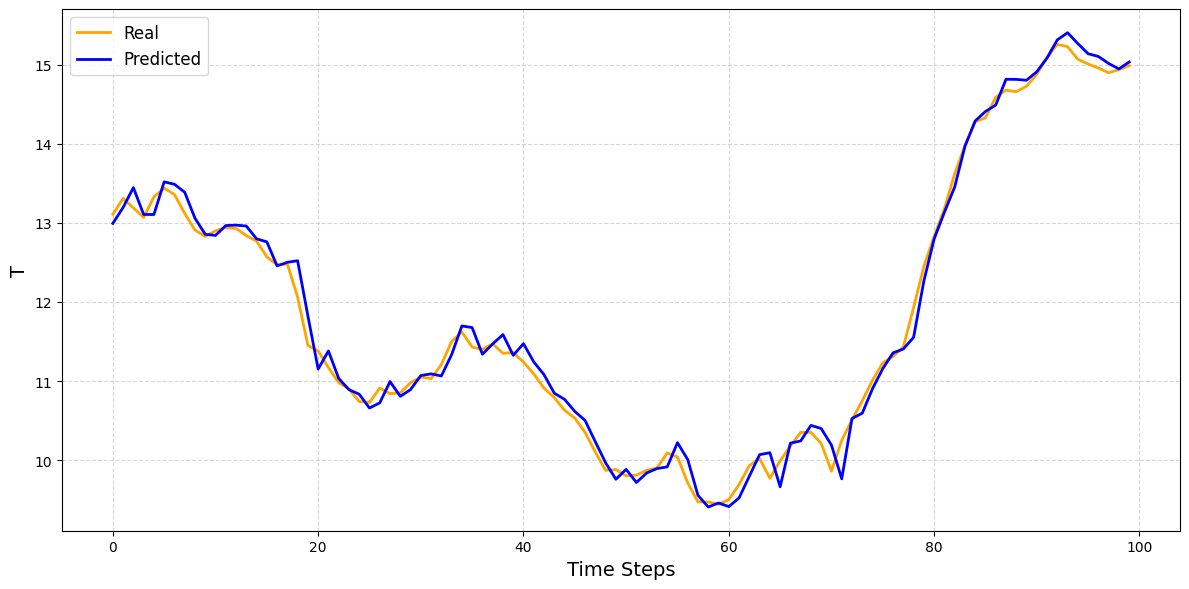

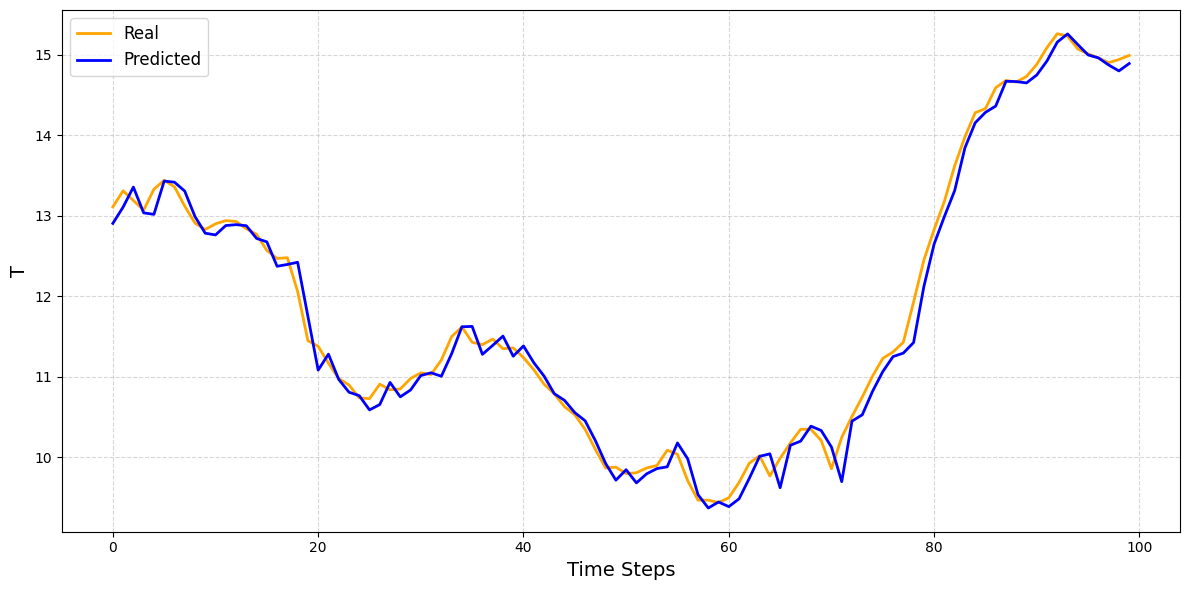

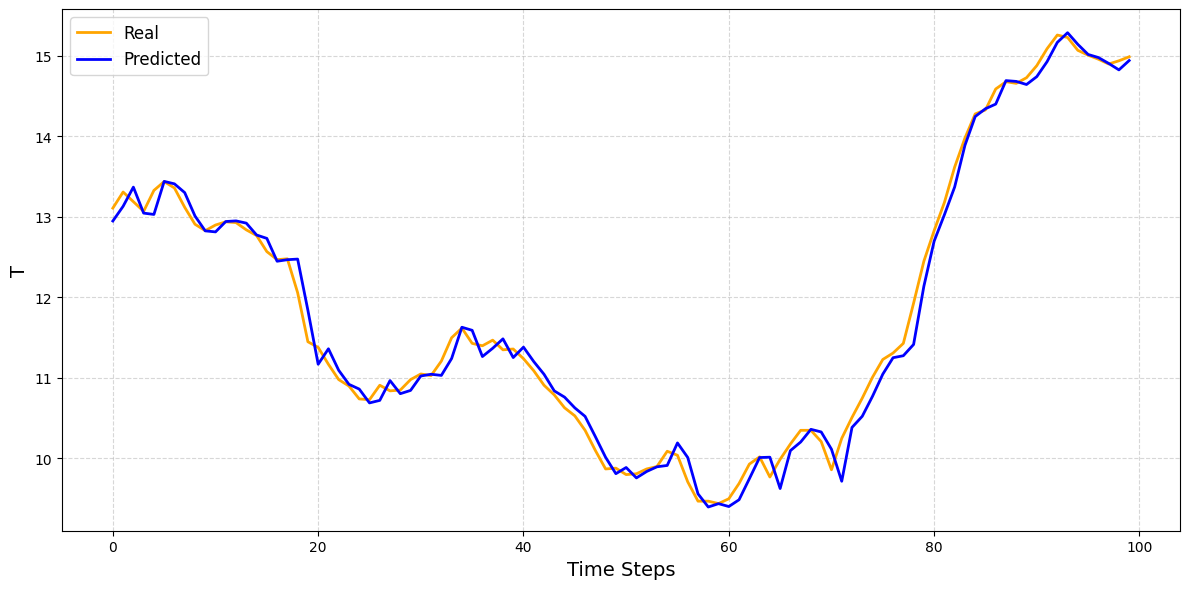

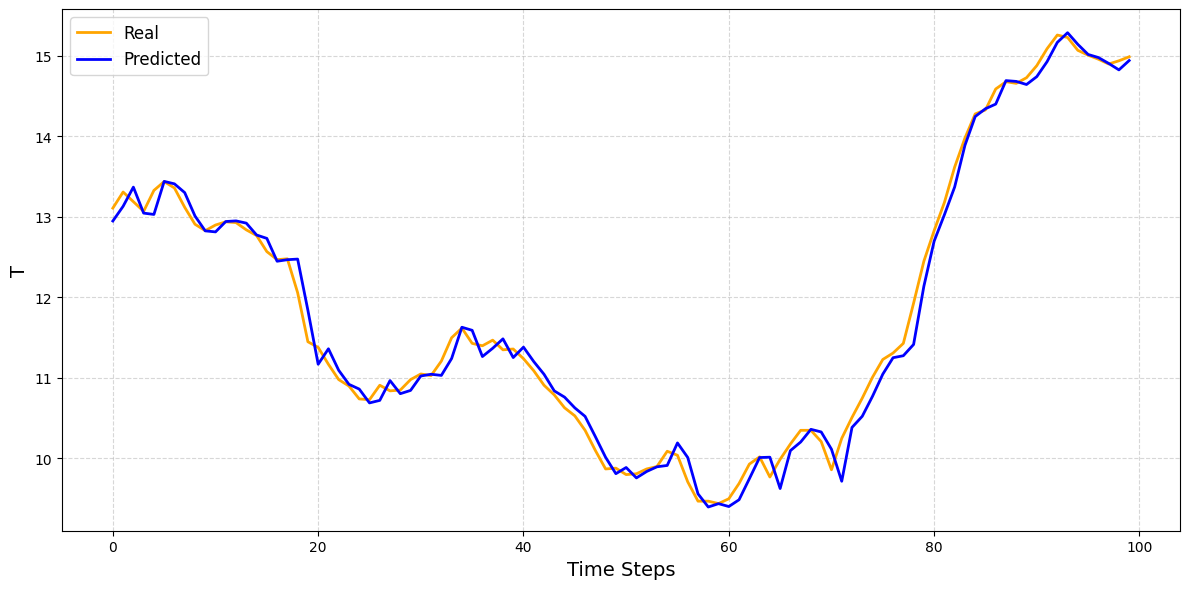

In [ ]:
# Zoom - IN
data_module.setup(stage="test")
best_models = [best_model_I, best_model_II, best_model_attention, best_model_attention]

for model in best_models:
    real_values = []
    predicted_values = []

    device = next(model.parameters()).device
    for batch in data_module.test_dataloader():
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predictions = model(x)

        # Append CPU-converted results
        real_values.extend(y.cpu().numpy())
        predicted_values.extend(predictions.cpu().detach().numpy())

    # Denormalize real and predicted values using target_scaler
    real_values_original = data_module.target_scaler.inverse_transform(
        np.array(real_values).reshape(-1, 1)
    ).flatten()

    predicted_values_original = data_module.target_scaler.inverse_transform(
        np.array(predicted_values).reshape(-1, 1)
    ).flatten()

    # Create DataFrame with denormalized values
    results_df_original = pd.DataFrame({
        "Real": real_values_original,
        "Predicted": predicted_values_original
    })

    focus_range = slice(700, 800)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(real_values_original[focus_range], label="Real", color='orange', linewidth=2)
    plt.plot(predicted_values_original[focus_range], label="Predicted", color='blue', linewidth=2)
    #plt.title("Zoomed-in view", fontsize=16)
    plt.xlabel("Time Steps", fontsize=14)
    plt.ylabel("T", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Baseline Model

### Define the model

In [ ]:
# Define baseline model
def create_baseline_model(input_size):
    return nn.Sequential(
        nn.Linear(input_size, 100),
        nn.ReLU(),
        nn.Linear(100, 1)
    )

# Baseline training class
class BaselineModel(pytorch_lightning.LightningModule):
    def __init__(self, input_size, learning_rate):
        super().__init__()
        self.model = create_baseline_model(input_size)
        self.criterion = nn.L1Loss()  # MAE loss
        self.rmse = torchmetrics.MeanSquaredError(squared=False)  # RMSE metric
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x).squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Flatten input: [batch_size, w, input_size] -> [batch_size, w * input_size]
        x = x.reshape(x.size(0), -1)
        y_pred = self(x)
        y = y.squeeze(1)  # Remove the extra dimension from target
        loss = self.criterion(y_pred, y)
        rmse = self.rmse(y_pred, y)
        self.log('train_loss', loss)
        self.log('train_rmse', rmse)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # Flatten input: [batch_size, w, input_size] -> [batch_size, w * input_size]
        x = x.reshape(x.size(0), -1)
        y_pred = self(x)
        y = y.squeeze(1)  # Remove the extra dimension from target
        loss = self.criterion(y_pred, y)
        rmse = self.rmse(y_pred, y)
        self.log('val_loss', loss)
        self.log('val_rmse', rmse)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        # Flatten input: [batch_size, w, input_size] -> [batch_size, w * input_size]
        x = x.reshape(x.size(0), -1)
        y_pred = self(x)
        y = y.squeeze(1)  # Remove the extra dimension from target
        loss = self.criterion(y_pred, y)
        rmse = self.rmse(y_pred, y)
        self.log('test_loss', loss)
        self.log('test_rmse', rmse)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

### Train the baseline model

In [ ]:
import os
baseline_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/baseline"
os.makedirs(baseline_path, exist_ok=True)
# Baseline
baseline_data_module = WeatherDataModule(
    df=df,
    w=4, h=1, batch_size=8
    )
baseline_data_module.setup(stage='fit')

learning_rates = [0.1, 0.01, 0.001, 0.0001]
best_model = None
best_val_loss = float('inf')

input_size = len([col for col in df.columns if col not in ['date', 'T']]) * 4

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = BaselineModel(input_size=input_size, learning_rate=lr)

    trainer = pytorch_lightning.Trainer(
        max_epochs=100,
        callbacks=[
            pytorch_lightning.callbacks.EarlyStopping(
                monitor='val_loss', patience=5,
                ),
            pytorch_lightning.callbacks.ModelCheckpoint(
                monitor='val_loss', save_top_k=1, mode='min',dirpath=baseline_path,filename=f'baseline_best_model'
                )
        ],
        logger=CSVLogger(save_dir=baseline_path,name='baseline_csv_logs',version=None)
    )

    trainer.fit(
        model,
        train_dataloaders=baseline_data_module.train_dataloader(),
        val_dataloaders=baseline_data_module.val_dataloader()
        )

    val_loss = trainer.callback_metrics['val_loss'].item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

print(f"Best baseline model with learning rate: {best_model.learning_rate}, Validation Loss: {best_val_loss}")

# Evaluación del baseline
baseline_data_module.setup(stage='test')
trainer.test(best_model, dataloaders=baseline_data_module.test_dataloader())

### Baseline models results

In [ ]:
baseline_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/baseline"

# Ruta al directorio principal de los logs
logs_path = os.path.join(baseline_path, "baseline_csv_logs")

# Lista de learning rates usados (en el mismo orden que las versiones)
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Inicializar lista para almacenar resultados
results = []

# Procesar cada carpeta 'version_'
for version_index, lr in enumerate(learning_rates):
    version_dir = f"version_{version_index}"
    version_path = os.path.join(logs_path, version_dir)

    metrics_file = os.path.join(version_path, "metrics.csv")
    if os.path.exists(metrics_file):
        # Leer el archivo metrics.csv
        metrics_df = pd.read_csv(metrics_file)

        # Buscar última fila válida para entrenamiento
        last_train_metrics = metrics_df.dropna(subset=['train_loss']).iloc[-1] if not metrics_df['train_loss'].dropna().empty else None
        last_val_metrics = metrics_df.dropna(subset=['val_loss']).iloc[-1] if not metrics_df['val_loss'].dropna().empty else None
        #last_test_metrics = metrics_df.dropna(subset=['test_loss']).iloc[-1] if not metrics_df['test_loss'].dropna().empty else None

        # Extraer métricas de entrenamiento
        if last_train_metrics is not None:
            mae_train = last_train_metrics['train_rmse']
            rmse_train = np.sqrt(last_train_metrics['train_loss'])
        else:
            mae_train = None
            rmse_train = None

        # Extraer métricas de validación
        if last_val_metrics is not None:
            mae_val = last_val_metrics['val_rmse']
            rmse_val = np.sqrt(last_val_metrics['val_loss'])
        else:
            mae_val = None
            rmse_val = None


        # Agregar resultados
        results.append({
            "Modelo":"Baseline",
            "Learning Rate": lr,
            "MAE Train": mae_train,
            "RMSE Train": rmse_train,
            "MAE Validation": mae_val,
            "RMSE Validation": rmse_val

        })

# Crear un DataFrame con los resultados
results_baseline = pd.DataFrame(results)
results_baseline

,Modelo,Learning Rate,MAE Train,RMSE Train,MAE Validation,RMSE Validation
0,Baseline,0.1000,7.321692,2.274907,6.729980,2.589588
1,Baseline,0.0100,0.979954,0.913277,0.721254,0.833610
2,Baseline,0.0010,0.377148,0.511547,0.238013,0.447029
3,Baseline,0.0001,0.259898,0.467496,0.337610,0.541823


## Models results comparison

In [ ]:
import os
columns = ["Modelo", "MAE Train", "MAE Validation", "MAE Test"]
results = pd.DataFrame(columns=columns)
results

# Best baseline model
baseline_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/baseline"
# Ruta al directorio principal de los logs
logs_path = os.path.join(baseline_path, "baseline_csv_logs")

metrics_file = os.path.join(logs_path, "version_3/metrics.csv")
metrics_df = pd.read_csv(metrics_file)

mae_train = metrics_df.dropna(subset=['train_loss']).iloc[-1]['train_loss']
mae_val = metrics_df.dropna(subset=['val_loss']).iloc[-1]['val_loss']
mae_test = metrics_df.dropna(subset=['test_loss']).iloc[-1]['test_loss']

baseline_row = {
    "Modelo": "Baseline",
    "MAE Train": mae_train,
    "MAE Validation": mae_val,
    "MAE Test": mae_test
}

results = pd.concat([results, pd.DataFrame([baseline_row])], ignore_index=True)

# LSTM_I
experiment_name = "experiment_20250120-130107"

experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_I/"
logs_path = "/csv_logs/version_0/metrics.csv"

# Read logs
metrics_df = pd.read_csv(experiment_path + experiment_name + logs_path)

mae_train = metrics_df.dropna(subset=['train_loss_epoch']).iloc[-1]['train_loss_epoch']
mae_val = metrics_df.dropna(subset=['val_loss']).iloc[-1]['val_loss']
mae_test = metrics_df.dropna(subset=['test_loss']).iloc[-1]['test_loss']

lstm1_row = {
    "Modelo": "LSTM I (lr=0.001)",
    "MAE Train": mae_train,
    "MAE Validation": mae_val,
    "MAE Test": mae_test
}

results = pd.concat([results, pd.DataFrame([lstm1_row])], ignore_index=True)

# LSTM_II
experiment_name = "experiment_20250120-130830"

experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_II/"
logs_path = "/csv_logs/version_0/metrics.csv"

# Read logs
metrics_df = pd.read_csv(experiment_path + experiment_name + logs_path)

mae_train = metrics_df.dropna(subset=['train_loss_epoch']).iloc[-1]['train_loss_epoch']
mae_val = metrics_df.dropna(subset=['val_loss']).iloc[-1]['val_loss']
mae_test = metrics_df.dropna(subset=['test_loss']).iloc[-1]['test_loss']

lstm1_row = {
    "Modelo": "LSTM II (lr=0.005)",
    "MAE Train": mae_train,
    "MAE Validation": mae_val,
    "MAE Test": mae_test
}

results = pd.concat([results, pd.DataFrame([lstm1_row])], ignore_index=True)


# LSTM_III
experiment_name = "experiment_lr_5e-4"

experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_III/"
logs_path = "/csv_logs/version_0/metrics.csv"

# Read logs
metrics_df = pd.read_csv(experiment_path + experiment_name + logs_path)

mae_train = metrics_df.dropna(subset=['train_loss_epoch']).iloc[-1]['train_loss_epoch']
mae_val = metrics_df.dropna(subset=['val_loss']).iloc[-1]['val_loss']
mae_test = metrics_df.dropna(subset=['test_loss']).iloc[-1]['test_loss']

lstm2_row = {
    "Modelo": "LSTM III (lr=0.0005)",
    "MAE Train": mae_train,
    "MAE Validation": mae_val,
    "MAE Test": mae_test
}

results = pd.concat([results, pd.DataFrame([lstm2_row])], ignore_index=True)

# LSTM_Attention
experiment_name = "experiment_20250120-130350"

experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_Attention/"
logs_path = "/csv_logs/version_0/metrics.csv"

# Read logs
metrics_df = pd.read_csv(experiment_path + experiment_name + logs_path)

mae_train = metrics_df.dropna(subset=['train_loss']).iloc[-1]['train_loss']
mae_val = metrics_df.dropna(subset=['val_loss']).iloc[-1]['val_loss']
mae_test = metrics_df.dropna(subset=['test_loss']).iloc[-1]['test_loss']

lstm1_row = {
    "Modelo": "LSTM + Attention (158 hidden size)",
    "MAE Train": mae_train,
    "MAE Validation": mae_val,
    "MAE Test": mae_test
}

results = pd.concat([results, pd.DataFrame([lstm1_row])], ignore_index=True)


# LSTM_Attention II
experiment_name = "experiment_hiddensize_256"

experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_Attention_II/"
logs_path = "/csv_logs/version_0/metrics.csv"

# Read logs
metrics_df = pd.read_csv('/content/drive/MyDrive/deep_learning/weather_forecasting/LSTM_Attention_II/experiment_hiddensize_256/csv_logs/version_0/metrics.csv')

mae_train = metrics_df.dropna(subset=['train_loss']).iloc[-1]['train_loss']
mae_val = metrics_df.dropna(subset=['val_loss']).iloc[-1]['val_loss']
mae_test = metrics_df.dropna(subset=['test_loss']).iloc[-1]['test_loss']

lstm2_row = {
    "Modelo": "LSTM + Attention II (256 hidden size)",
    "MAE Train": mae_train,
    "MAE Validation": mae_val,
    "MAE Test": mae_test
}
results = pd.concat([results, pd.DataFrame([lstm2_row])], ignore_index=True)

results

<ipython-input-42-149c92d3f9ab>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([baseline_row])], ignore_index=True)


,Modelo,MAE Train,MAE Validation,MAE Test
0,Baseline,0.218553,0.293572,0.138367
1,LSTM I (lr=0.001),0.004249,0.004601,0.004066
2,LSTM II (lr=0.005),0.006200,0.006726,0.011937
3,LSTM III (lr=0.0005),0.004301,0.004980,0.006234
4,LSTM + Attention (158 hidden size),0.000050,0.000035,0.000034
5,LSTM + Attention II (256 hidden size),0.000044,0.000041,0.000024


## Best model demo

In [ ]:
experiment_path = "/content/drive/MyDrive/deep_learning/weather_forecasting/"
logs_path = "/csv_logs/version_0/metrics.csv"
experiment_name_attention = "LSTM_Attention_II/experiment_hiddensize_256"


# Initialize DataModule
data_module = WeatherDataModule(
    df=df,
    w=24,               # Window size (24 time steps)
    h=1,                # Horizon (predict 1 step ahead)
    batch_size=128,     # Batch size
    val_size=0.2,       # Validation set size
    test_size=0.2       # Test set size
)

data_module.setup(stage='test')
test_loader = data_module.test_dataloader()


# Best model
best_model_path = experiment_path + experiment_name_attention + "/best_model.ckpt"
# Load best model
best_model_attention = AttentionLSTMTrainer.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=AdvancedAttentionLSTMRegressor(h=h, input_size=input_size,
                                       hidden_size=hidden_size,
                                       num_layers=num_layers,
                                       batch_first=True,
                                       p_drop=p_drop,
                                       pooling_type=pooling_type),
    learning_rate=1e-3
)

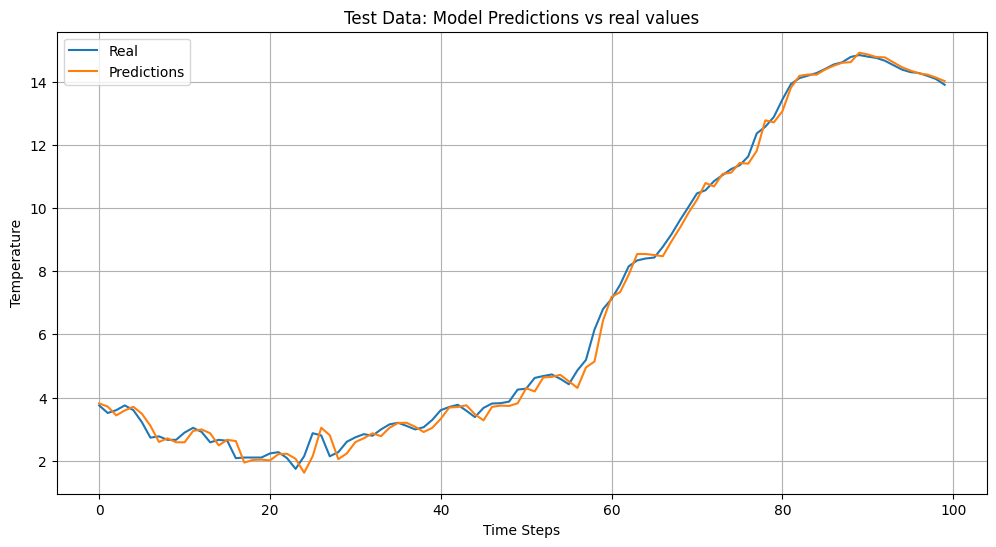

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

best_model_attention.eval()  # Ensure the model is in evaluation mode

test_predictions = []
ground_truth = []
device = next(best_model_attention.parameters()).device
best_model_attention.to(device)  # Move the model to the correct device

with torch.no_grad():
    for batch in test_loader:
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)

        predictions = best_model_attention(features)
        test_predictions.append(predictions.cpu().numpy())  # Convert to numpy on CPU
        ground_truth.append(targets.cpu().numpy())  # Convert to numpy on CPU

# Convert lists to arrays for easier processing
test_predictions = np.concatenate(test_predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

# **Denormalize predictions and ground truth**
denormalized_predictions = data_module.target_scaler.inverse_transform(
    test_predictions.reshape(-1, 1)
).flatten()

denormalized_ground_truth = data_module.target_scaler.inverse_transform(
    ground_truth.reshape(-1, 1)
).flatten()

# Plot predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.plot(denormalized_ground_truth[:100], label="Real")  # Plot first 100 samples
plt.plot(denormalized_predictions[:100], label="Predictions")
plt.title("Test Data: Model Predictions vs real values")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


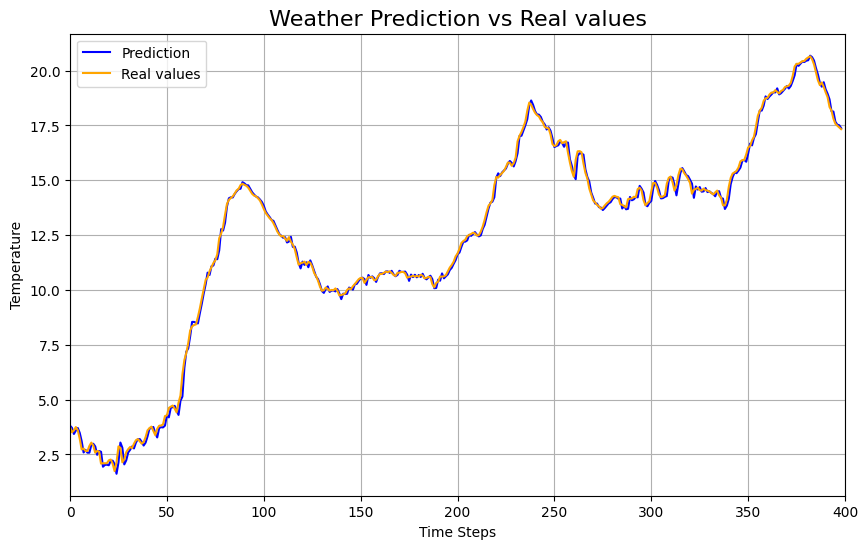

In [ ]:
from matplotlib.animation import FuncAnimation

# Denormalize real and predicted values using target_scaler
denormalized_predictions = data_module.target_scaler.inverse_transform(
    np.array(test_predictions[:400]).reshape(-1, 1)
).flatten()

denormalized_ground_truth = data_module.target_scaler.inverse_transform(
    np.array(ground_truth[:400]).reshape(-1, 1)
).flatten()

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Weather Prediction vs Real values", fontsize=16)
ax.set_xlim(0, len(denormalized_predictions))  # Time steps
ax.set_ylim(
    min(min(denormalized_predictions), min(denormalized_ground_truth)) - 1,
    max(max(denormalized_predictions), max(denormalized_ground_truth)) + 1
)
ax.set_xlabel("Time Steps")
ax.set_ylabel("Temperature")
ax.grid()

# Initialize lines for predictions and ground truth
prediction_line, = ax.plot([], [], label="Prediction", color="blue")
ground_truth_line, = ax.plot([], [], label="Real values", color="orange")
ax.legend()

# Update function for the animation
def update(frame):
    # Update the data for the current frame
    prediction_line.set_data(range(frame), denormalized_predictions[:frame])
    ground_truth_line.set_data(range(frame), denormalized_ground_truth[:frame])
    return prediction_line, ground_truth_line

# Create the animation
ani = FuncAnimation(
    fig, update, frames=len(denormalized_predictions), interval=100, blit=True
)  # interval=100ms for smooth animation

# Save the animation as a video file
ani.save("/content/drive/MyDrive/deep_learning/weather_forecasting/dynamic_weather_prediction.mp4",
         writer="ffmpeg", fps=30)

plt.show()